In [ ]:
# REFERENCE FOR CCL, from https://github.com/cmbant/SZCl_like/blob/methods/szcl_like/szcl_like.py

import numpy as np
import pyccl as ccl
from cobaya.likelihood import Likelihood
from scipy.interpolate import interp1d

from .theory import HaloProfileArnaud, SZTracer


class SZModel:
    pass


class SZClLike(Likelihood):
    cl_file: str = "data/cl_yy.fits"
    map_name: str = "SO_y"
    l_min: int = 100
    l_max: int = 3000

    params = {"b_hydro": 0.2}

    def initialize(self):
        self.nl_per_decade = 5
        self.mdef = ccl.halos.MassDef(500, "critical")
        self.prof = HaloProfileArnaud(0.2)
        self._read_data()
        self.ks = np.geomspace(1e-4, 100, 256)
        self.lks = np.log(self.ks)
        self.a_s = np.linspace(0.1, 1, 10)
        self.add_2h = False

    def get_requirements(self):
        return {"CCL": {"methods": {"sz_model": self._get_sz_model}, "kmax": 10}}

    def _read_data(self):
        import sacc

        # Read data vector and covariance
        s = sacc.Sacc.load_fits(self.cl_file)
        if self.map_name not in list(s.tracers.keys()):
            raise KeyError("Map not found")

        inds = s.indices(
            "cl_00",
            (self.map_name, self.map_name),
            ell__gt=self.l_min,
            ell__lt=self.l_max,
        )
        s.keep_indices(inds)
        ls, cl, win = s.get_ell_cl(
            "cl_00", self.map_name, self.map_name, return_windows=True
        )
        self.leff = ls
        self.data = cl
        self.cov = s.covariance.covmat
        self.invcov = np.linalg.inv(self.cov)

        # Read bandpower window functions
        self.ls_all = win.values
        self.l_ls_all = np.log(self.ls_all)
        self.windows = win.weight.T

        # Read beam and resample
        t = s.get_tracer(self.map_name)
        beam_f = interp1d(t.ell, t.beam_ell, bounds_error=False, fill_value=0)
        self.beam2 = beam_f(self.ls_all) ** 2

        # Compute ell nodes
        l10_lmax = np.log10(self.ls_all[-1])
        n_sample = int(l10_lmax * self.nl_per_decade) + 1
        self.ls_sample = np.unique(np.logspace(0, l10_lmax, n_sample).astype(int)).astype(
            float
        )
        self.l_ls_sample = np.log(self.ls_sample)

    def _get_sz_model(self, cosmo):
        model = SZModel()
        model.hmf = ccl.halos.MassFuncTinker08(cosmo, mass_def=self.mdef)
        model.hmb = ccl.halos.HaloBiasTinker10(
            cosmo, mass_def=self.mdef, mass_def_strict=False
        )
        model.hmc = ccl.halos.HMCalculator(cosmo, model.hmf, model.hmb, self.mdef)
        model.szk = SZTracer(cosmo)
        return model

    def _get_theory(self, **pars):
        results = self.provider.get_CCL()
        cosmo = results["cosmo"]
        sz_model = results["sz_model"]

        self.prof._update_bhydro(pars["b_hydro"])
        pk2d = ccl.halos.halomod_Pk2D(
            cosmo,
            sz_model.hmc,
            self.prof,
            lk_arr=self.lks,
            a_arr=self.a_s,
            get_2h=self.add_2h,
        )
        cls = ccl.angular_cl(
            cosmo, sz_model.szk, sz_model.szk, self.ls_sample, p_of_k_a=pk2d
        )
        clf = interp1d(self.l_ls_sample, np.log(cls), bounds_error=False, fill_value=-200)
        cls = np.exp(clf(self.l_ls_all)) * self.beam2
        cls = np.dot(self.windows, cls)
        return cls

    def logp(self, **pars):
        t = self._get_theory(**pars)
        r = t - self.data
        chi2 = np.dot(r, self.invcov.dot(r))
        return -0.5 * chi2

In [23]:
cosmo = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.7, n_s=0.95, sigma8=0.8, transfer_function="bbks"
)
mdef = ccl.halos.MassDef(500, "critical")
hmf = ccl.halos.MassFuncTinker08(cosmo, mass_def=mdef)
# hmb = ccl.halos.HaloBiasTinker10(cosmo, mass_def=mdef, mass_def_strict=False)
# hmc = ccl.halos.HMCalculator(cosmo,hmf,hmb, mdef)

In [25]:
hmf.get_mass_function(
    cosmo,
)

Signature: hmf.get_mass_function(cosmo, M, a, mdef_other=None)
Docstring:
Returns the mass function for input parameters.

Args:
    cosmo (:class:`~pyccl.core.Cosmology`): A Cosmology object.
    M (float or array_like): halo mass in units of M_sun.
    a (float): scale factor.
    mdef_other (:class:`~pyccl.halos.massdef.MassDef`):
        the mass definition object that defines M.

Returns:
    float or array_like: mass function                 :math:`dn/d\log_{10}M` in units of Mpc^-3.
File:      ~/miniconda3/envs/soliket/lib/python3.8/site-packages/pyccl/halos/hmfunc.py
Type:      method


In [1]:
from soliket.tests.test_clusters import test_clusters

In [2]:
like = test_clusters()

[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *auto-installed* CAMB (but defaulting to *global*).
[camb] Initialized!
mock catalog
Ntot 368.36238138205863
Ntot 368.36238138205863


In [3]:
hmf_soliket = like._get_HMF()

In [5]:
dndm_soliket = hmf_soliket.dn_dM(hmf_soliket.M, 500)

In [28]:
import pyccl as ccl

pars = {
    "ombh2": 0.02225,
    "omch2": 0.1198,
    "H0": 67.3,
    "tau": 0.06,
    "As": 2.2e-9,
    "ns": 0.96,
    "mnu": 0.06,
    "nnu": 3.046,
}

h = pars["H0"] / 100

cosmo = ccl.Cosmology(
    Omega_c=pars["omch2"] / h**2,
    Omega_b=pars["ombh2"] / h**2,
    h=h,
    n_s=pars["ns"],
    A_s=pars["As"],
)
mdef = ccl.halos.MassDef(500, "critical")
hmf = ccl.halos.MassFuncTinker08(cosmo, mass_def=mdef)
# hmb = ccl.halos.HaloBiasTinker10(cosmo, mass_def=mdef, mass_def_strict=False)
# hmc = ccl.halos.HMCalculator(cosmo,hmf,hmb, mdef)

In [29]:
hmf.get_mass_function(cosmo, 1e14, 1)

2.598983920243067e-05

In [30]:
def z_to_a(z):
    return 1 / (1 + z)


dndm_ccl = hmf.get_mass_function(cosmo, hmf_soliket.M, z_to_a(0))

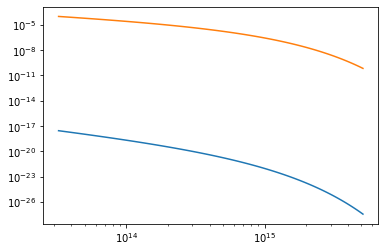

In [31]:
import matplotlib.pyplot as plt

plt.loglog(hmf_soliket.M, dndm_soliket[:, 0])
plt.loglog(hmf_soliket.M, dndm_ccl)

In [21]:
hmf_soliket.zarr

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95])

In [16]:
dndm_soliket.shape

(111, 40)

In [ ]:
hmf

In [8]:
# fiducial_params = {
#    "ombh2": 0.02225,
#    "omch2": 0.1198,
#    "H0": 67.3,
#    "tau": 0.06,
#    "As": 2.2e-9,
#    "ns": 0.96,
#    "mnu": 0.06,
#    "nnu": 3.046,
#    "num_massive_neutrinos": 3,
#    }

fiducial_params = {
    "omch2": 0.125,  # FOR Testing against NEMO
    "ombh2": 0.02225,
    "H0": 70.0,
    "ns": 0.95,
    "As": 1.88e-9,
    "mnu": 0.0,
    "tau": 0.06,
    "nnu": 3.046,
    "num_massive_neutrinos": 0,
}

info_fiducial = {
    "params": fiducial_params,
    "likelihood": {
        "soliket.ClusterLikelihood": {
            "stop_at_error": True,
        }
    },
    "theory": {
        "camb": {
            "extra_args": {
                "accurate_massive_neutrino_transfers": True,
                "redshifts": np.linspace(0, 2, 41),
                "nonlinear": False,
                "kmax": 10.0,
                "dark_energy_model": "ppf",
            }
        }
    },
    "modules": "/Users/nab/Repos/cobaya_modules/",
}

from cobaya.model import get_model

model_fiducial = get_model(info_fiducial)

lnl = model_fiducial.loglikes({})[0]

# assert np.isfinite(lnl)

print(lnl)

[model] *WARNING* Ignored blocks/options: ['modules']
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *auto-installed* CAMB (but defaulting to *global*).
[camb] Initialized!
mock catalog
[model] *ERROR* Could not find anything to use input parameter(s) {'num_massive_neutrinos'}.


LoggedError: Could not find anything to use input parameter(s) {'num_massive_neutrinos'}.

In [3]:
3.20111782e03

3201.11782

In [4]:
import numpy as np


def to_array(s):
    return np.array(s[1:-1].split(), dtype=float)

In [5]:
cob = to_array("""[1.91779243e+03 2.02043522e+03 2.12855762e+03 2.24244963e+03
 2.36241634e+03 2.48877875e+03 2.62187453e+03 2.76205814e+03
 2.90970115e+03 3.06519399e+03 3.22894690e+03 3.40139093e+03
 3.58297892e+03 3.77418527e+03 3.97550527e+03 4.18745804e+03
 4.41058787e+03 4.64546533e+03 4.89268844e+03 5.15288194e+03
 5.42669391e+03 5.71480064e+03 6.01790860e+03 6.33675557e+03
 6.67211169e+03 7.02477837e+03 7.39558064e+03 7.78537346e+03
 8.19504490e+03 8.62551693e+03 9.07774596e+03 9.55272067e+03
 1.00514449e+04 1.05749451e+04 1.11242775e+04 1.17005267e+04
 1.23048059e+04 1.29382521e+04 1.36019888e+04 1.42971316e+04
 1.50248051e+04 1.57861398e+04 1.65822683e+04 1.74143183e+04
 1.82833544e+04 1.91903699e+04 2.01363175e+04 2.11221033e+04
 2.21485784e+04 2.32165276e+04 2.43266008e+04 2.54792770e+04
 2.66749101e+04 2.79137192e+04 2.91957749e+04 3.05209844e+04
 3.18890065e+04 3.32991725e+04 3.47505614e+04 3.62419926e+04
 3.77720101e+04 3.93388662e+04 4.09403760e+04 4.25738469e+04
 4.42362560e+04 4.59240163e+04 4.76331064e+04 4.93588929e+04
 5.10982056e+04 5.28417581e+04 5.45838221e+04 5.63176167e+04
 5.80352782e+04 5.97262636e+04 6.13841174e+04 6.29975068e+04
 6.45553581e+04 6.60468956e+04 6.74577059e+04 6.87752551e+04
 6.99847667e+04 7.10720822e+04 7.20214786e+04 7.28172055e+04
 7.34432459e+04 7.38835866e+04 7.41227154e+04 7.41457834e+04
 7.39392103e+04 7.34913294e+04 7.27928765e+04 7.18378044e+04
 7.06240224e+04 6.91542061e+04 6.74366392e+04 6.54858826e+04
 6.33234412e+04 6.09780869e+04 5.84858334e+04 5.58895332e+04
 5.32378205e+04 5.05840145e+04 4.79630796e+04 4.54224823e+04
 4.30385157e+04 4.08557009e+04 3.88968418e+04 3.71592962e+04
 3.56181247e+04 3.42350631e+04 3.29663004e+04 3.18098809e+04
 3.05843590e+04 2.92501650e+04 2.77064598e+04 2.59132781e+04
 2.39074933e+04 2.17954123e+04 1.97133494e+04 1.77946499e+04
 1.61557214e+04 1.48721871e+04 1.39382623e+04 1.32485331e+04
 1.26198168e+04 1.18527091e+04 1.08509723e+04 9.69437476e+03
 8.55992287e+03 7.63650650e+03 7.01472218e+03 6.58542901e+03
 6.15596301e+03 5.58909113e+03 4.93536714e+03 4.36863082e+03
 3.98167143e+03 3.68399492e+03 3.34031328e+03 2.95568751e+03
 2.63780905e+03 2.40219255e+03 2.16883372e+03 1.92501648e+03
 1.72420458e+03 1.55354656e+03 1.38366898e+03 1.23456422e+03
 1.10486489e+03 9.82938251e+02 8.76280481e+02 7.79834652e+02
 6.93233007e+02 6.16067978e+02 5.46779357e+02 4.85137772e+02
 4.30017945e+02 3.80822296e+02 3.36995234e+02 2.98014280e+02
 2.63374515e+02 2.32611045e+02 2.05306795e+02 1.81088539e+02
 1.59624748e+02 1.40617952e+02 1.23800464e+02 1.08931516e+02
 9.57944513e+01 8.41952818e+01 7.39606670e+01 6.49358828e+01
 5.69829716e+01 4.99789879e+01 4.38144578e+01 3.83919637e+01
 3.36248822e+01 2.94363101e+01 2.57580338e+01 2.25295874e+01
 1.96974140e+01 1.72141215e+01 1.50378042e+01 1.31314262e+01
 1.14622810e+01 1.00015115e+01 8.72367363e+00 7.60634294e+00
 6.62977051e+00 5.77657697e+00 5.03147658e+00 4.38103006e+00
 3.81343009e+00 3.31831045e+00 2.88657462e+00 2.51024377e+00
 2.18232329e+00 1.89668454e+00 1.64795992e+00 1.43144986e+00]""")

szr = to_array("""[3.99959066e+02 4.21378684e+02 4.43944152e+02 4.67716481e+02
 4.92759892e+02 5.19142053e+02 5.46934224e+02 5.76211346e+02
 6.07052230e+02 6.39539788e+02 6.73761212e+02 7.09808222e+02
 7.47777240e+02 7.87769667e+02 8.29892034e+02 8.74256282e+02
 9.20979975e+02 9.70186506e+02 1.02200542e+03 1.07657251e+03
 1.13403026e+03 1.19452802e+03 1.25822238e+03 1.32527715e+03
 1.39586363e+03 1.47016101e+03 1.54835636e+03 1.63064521e+03
 1.71723131e+03 1.80832725e+03 1.90415433e+03 2.00494291e+03
 2.11093202e+03 2.22236882e+03 2.33950982e+03 2.46262043e+03
 2.59197553e+03 2.72785797e+03 2.87055917e+03 3.02037819e+03
 3.17762108e+03 3.34260128e+03 3.51563765e+03 3.69705536e+03
 3.88718255e+03 4.08635126e+03 4.29489467e+03 4.51314609e+03
 4.74143838e+03 4.98010073e+03 5.22945874e+03 5.48982857e+03
 5.76151810e+03 6.04482211e+03 6.34002097e+03 6.64737481e+03
 6.96711777e+03 7.29945766e+03 7.64456484e+03 8.00257470e+03
 8.37357443e+03 8.75760361e+03 9.15464354e+03 9.56461105e+03
 9.98735657e+03 1.04226508e+04 1.08701852e+04 1.13295465e+04
 1.18002235e+04 1.22815761e+04 1.27728351e+04 1.32731059e+04
 1.37813561e+04 1.42964163e+04 1.48169507e+04 1.53414691e+04
 1.58682528e+04 1.63953844e+04 1.69207645e+04 1.74421085e+04
 1.79569088e+04 1.84623275e+04 1.89553252e+04 1.94326115e+04
 1.98907127e+04 2.03258626e+04 2.07340482e+04 2.11110486e+04
 2.14523661e+04 2.17534120e+04 2.20093514e+04 2.22153670e+04
 2.23665450e+04 2.24580787e+04 2.24853736e+04 2.24441070e+04
 2.23305342e+04 2.21415541e+04 2.18749713e+04 2.15298022e+04
 2.11063629e+04 2.06067485e+04 2.00348197e+04 1.93965339e+04
 1.87000904e+04 1.79557425e+04 1.71757830e+04 1.63744588e+04
 1.55671968e+04 1.47699834e+04 1.39986753e+04 1.32679402e+04
 1.25901552e+04 1.19742686e+04 1.14246773e+04 1.09401262e+04
 1.05129124e+04 1.01284973e+04 9.76586715e+03 9.39921540e+03
 9.00121925e+03 8.54819731e+03 8.02624443e+03 7.43761673e+03
 6.80300629e+03 6.15983533e+03 5.55452066e+03 5.02967760e+03
 4.61256052e+03 4.30514229e+03 4.08076831e+03 3.88899397e+03
 3.67147400e+03 3.38891165e+03 3.04581748e+03 2.69135197e+03
 2.38890399e+03 2.17480928e+03 2.03390299e+03 1.91027950e+03
 1.75082800e+03 1.55436243e+03 1.36977916e+03 1.23744874e+03
 1.14442938e+03 1.04645567e+03 9.29988839e+02 8.25070490e+02
 7.48608344e+02 6.79602744e+02 6.04786010e+02 5.39255810e+02
 4.86364586e+02 4.34525924e+02 3.86822224e+02 3.46462947e+02
 3.08584183e+02 2.74839080e+02 2.44870862e+02 2.17619114e+02
 1.93491423e+02 1.71746051e+02 1.52405141e+02 1.35114082e+02
 1.19686669e+02 1.05941447e+02 9.37100091e+01 8.28346085e+01
 7.31720589e+01 6.45935622e+01 5.69836560e+01 5.02384125e+01
 4.42642726e+01 3.89770959e+01 3.43013447e+01 3.01692810e+01
 2.65202037e+01 2.32998216e+01 2.04596366e+01 1.79563649e+01
 1.57514191e+01 1.38104293e+01 1.21028025e+01 1.06013436e+01
 9.28190080e+00 8.12303818e+00 7.10575194e+00 6.21320868e+00
 5.43050691e+00 4.74446732e+00 4.14344229e+00 3.61714382e+00
 3.15649242e+00 2.75348061e+00 2.40105002e+00 2.09298374e+00
 1.82380905e+00 1.58870882e+00 1.38344832e+00 1.20430917e+00]""")

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline

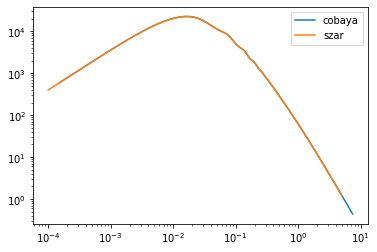

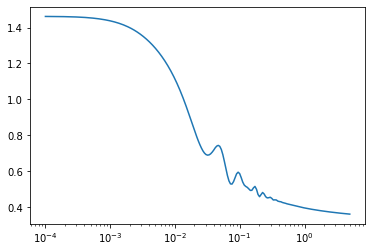

In [7]:
k = np.logspace(-4, np.log10(5), 200)
plt.loglog(k / 0.673, cob * 0.673**3, label="cobaya")
plt.plot(k, szr, label="szar")
plt.legend()

plt.figure()
plt.semilogx(k, cob * 0.673**3 / szr)